# Step 1 – Data Loading, Cleaning, and Integration

In this step, we construct the **merged analysis dataset** `data` from the two raw sources:

- **startup_success.csv** → startup outcomes and basic features  
- **investments_VC.csv** → detailed funding amounts (seed, A, B, …)

We perform:

1. **Loading**  
   - Parse date columns in the success dataset.  
   - Load investments with a tolerant encoding (`latin1`) to fix Unicode errors.

2. **Identifier creation**  
   - Build a shared `startup_id` by normalizing company names  
     (lowercase, remove punctuation/spaces).

3. **Cleaning & feature construction**  
   - Fix column names with extra spaces.  
   - Convert `funding_total_usd` to numeric.  
   - Define **early funding** = seed + angel + round_A.  
   - Add `early_total_funding_usd` and `early_round_count`.

4. **Binary success label**  
   - `success = 1` for operating/acquired/IPO  
   - `success = 0` for closed  
   - Drop rows with ambiguous outcomes.

5. **Merging**  
   - Merge on the shared `startup_id` (left join).  
   - Keep the Crunchbase funding variables as enrichment.  
   - Rename overlapping columns to  
     `funding_total_usd_main` and `funding_total_usd_cb`.

The resulting DataFrame **`data`** is the clean, enriched dataset used in Step 2 for EDA and hypothesis testing.


In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
# 1) Load raw CSVs
success = pd.read_csv(
    "data/startup_success.csv",
    encoding="utf-8",  # usually fine
    parse_dates=["founded_at", "first_funding_at", "last_funding_at", "closed_at"]
)

invest = pd.read_csv(
    "data/investments_VC.csv",
    encoding="latin1"
)

# 2) Drop unnamed columns from success
success = success.loc[:, ~success.columns.str.contains("^Unnamed")]

# 3) Normalize company names into a join key startup_id
def normalize_name(s):
    if pd.isna(s):
        return np.nan
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9]+", "", s)
    return s

success["startup_id"] = success["name"].apply(normalize_name)
invest["startup_id"]  = invest["name"].apply(normalize_name)

# 4) Fix invest column names and numeric funding
invest = invest.rename(columns={
    " market ": "market",
    " funding_total_usd ": "funding_total_usd"
})

if "funding_total_usd" in invest.columns:
    invest["funding_total_usd"] = (
        invest["funding_total_usd"]
        .astype(str)
        .str.replace(r"[^0-9.]", "", regex=True)
        .replace("", np.nan)
        .astype(float)
    )

# 5) Early funding = seed + round_A + angel (if present)
early_cols = [c for c in ["seed", "round_A", "angel"] if c in invest.columns]
invest["early_total_funding_usd"] = invest[early_cols].sum(axis=1)
invest["early_round_count"] = (invest[early_cols] > 0).sum(axis=1)

# 6) Binary success label from status
def label_status(s):
    s = str(s).lower()
    if s in ["operating", "acquired", "ipo"]:
        return 1
    elif s in ["closed"]:
        return 0
    return np.nan

success["success"] = success["status"].apply(label_status)
success_labeled = success.dropna(subset=["success"]).copy()
success_labeled["success"] = success_labeled["success"].astype(int)

# 7) Keep only needed columns from invest
cols_from_invest = [
    "startup_id",
    "market",
    "funding_total_usd",
    "seed", "venture", "angel", "round_A", "round_B", "round_C",
    "round_D", "round_E", "round_F", "round_G", "round_H",
    "equity_crowdfunding", "undisclosed", "convertible_note",
    "debt_financing", "grant", "private_equity",
    "post_ipo_equity", "post_ipo_debt", "secondary_market",
    "product_crowdfunding",
    "early_total_funding_usd", "early_round_count"
]
cols_from_invest = [c for c in cols_from_invest if c in invest.columns]
invest_subset = invest[cols_from_invest].copy()

# 8) Merge on startup_id
data = success_labeled.merge(invest_subset, on="startup_id", how="left")

# If startup_success already has a funding_total_usd, pandas will
# create funding_total_usd_x and funding_total_usd_y. Rename them:
data = data.rename(columns={
    "funding_total_usd_x": "funding_total_usd_main",
    "funding_total_usd_y": "funding_total_usd_cb"
})

# 9) Treat missing early funding as 0 for analysis
data["early_total_funding_usd"] = data["early_total_funding_usd"].fillna(0)
data["early_round_count"] = data["early_round_count"].fillna(0)

print("Shape of merged data:", data.shape)
print("Columns:", list(data.columns))
print("\nClass balance (success):")
print(data["success"].value_counts(normalize=True))


Shape of merged data: (927, 74)
Columns: ['state_code', 'latitude', 'longitude', 'zip_code', 'id', 'city', 'name', 'labels', 'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd_main', 'milestones', 'state_code.1', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'category_code', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'object_id', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'is_top500', 'status', 'startup_id', 'success', 'market', 'funding_total_usd_cb', 'seed', 'venture', 'angel', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing',

# Step 2 – Exploratory Data Analysis and Hypothesis Testing

In this step, we start from the **clean, merged dataset** `data` that was produced in Step 1.

- The target variable is **`success`** (1 = acquired, 0 = closed).
- The dataset combines:
  - Startup outcome and basic info from **startup_success.csv**, and  
  - Funding composition information (seed, A, B, …, total funding, etc.) from **investments_VC.csv**.

In this notebook we:

1. Perform **exploratory data analysis (EDA)** as described in the course:
   - Inspect structure, missingness, distributions.
   - Compare `success` with key categorical and numeric variables.
2. Formulate and test **six hypotheses (H1–H6)** using tools from the course:
   - Two-sample t-tests for numeric features.
   - Subgroup analysis by outcome-based age.


In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# If you DON'T have `data` in memory, uncomment and adapt this:
# success = pd.read_csv("startup_success.csv", parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])
# invest  = pd.read_csv("investments_VC.csv")
# (Merging / feature engineering done in Step 1...)
# data = ...  # final merged dataframe

# Quick sanity check
print("Shape of data:", data.shape)
print("\nColumns:\n", list(data.columns))

display(data.head())
data.info()


Shape of data: (927, 74)

Columns:
 ['state_code', 'latitude', 'longitude', 'zip_code', 'id', 'city', 'name', 'labels', 'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd_main', 'milestones', 'state_code.1', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'category_code', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'object_id', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'is_top500', 'status', 'startup_id', 'success', 'market', 'funding_total_usd_cb', 'seed', 'venture', 'angel', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'gra

,state_code,latitude,longitude,zip_code,id,city,name,labels,founded_at,closed_at,...,convertible_note,debt_financing,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,early_total_funding_usd,early_round_count
0,CA,42.358880,-71.056820,92101,c:6669,San Diego,Bandsintown,1,2007-01-01,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,TriCipher,1,2000-01-01,NaT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CA,32.901049,-117.192656,92121,c:65620,San Diego,Plixi,1,2009-03-18,NaT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2600000.0,1.0
3,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Solidcore Systems,1,2002-01-01,NaT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CA,37.779281,-122.419236,94105,c:65806,San Francisco,Inhale Digital,0,2010-08-01,2012-10-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1100000.0,1.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 927 entries, 0 to 926
Data columns (total 74 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   state_code                927 non-null    object        
 1   latitude                  927 non-null    float64       
 2   longitude                 927 non-null    float64       
 3   zip_code                  927 non-null    object        
 4   id                        927 non-null    object        
 5   city                      927 non-null    object        
 6   name                      927 non-null    object        
 7   labels                    927 non-null    int64         
 8   founded_at                927 non-null    datetime64[ns]
 9   closed_at                 336 non-null    datetime64[ns]
 10  first_funding_at          927 non-null    datetime64[ns]
 11  last_funding_at           927 non-null    datetime64[ns]
 12  age_first_funding_year

In [4]:
# 1. Class balance of the target
print("Class balance (success):")
print(data['success'].value_counts(normalize=True))

# 2. Quick summary of main numeric variables
num_cols = [
    'funding_total_usd_main',
    'funding_rounds',
    'relationships',
    'avg_participants',
    'age_first_funding_year',
    'early_total_funding_usd'
]
num_cols = [c for c in num_cols if c in data.columns]

print("\nNumeric summary of key variables:")
display(data[num_cols].describe())

# 3. Missing value ratios (top 15)
na_ratio = data.isna().mean().sort_values(ascending=False)
print("\nMissing value ratio (top 15 variables):")
display(na_ratio.head(15))


Class balance (success):
1    0.647249
0    0.352751
Name: success, dtype: float64

Numeric summary of key variables:


,funding_total_usd_main,funding_rounds,relationships,avg_participants,age_first_funding_year,early_total_funding_usd
count,9.270000e+02,927.000000,927.000000,927.000000,927.000000,9.270000e+02
mean,2.533754e+07,2.306365,7.702265,2.838204,2.237974,3.131130e+06
std,1.892286e+08,1.389949,7.252007,1.873081,2.508176,6.126830e+06
min,1.100000e+04,1.000000,0.000000,1.000000,-9.046600,0.000000e+00
25%,2.725000e+06,1.000000,3.000000,1.500000,0.576700,0.000000e+00
50%,1.000000e+07,2.000000,5.000000,2.500000,1.452100,1.000000e+06
75%,2.460527e+07,3.000000,10.000000,3.800000,3.575350,4.300000e+06
max,5.700000e+09,10.000000,63.000000,16.000000,21.895900,1.000000e+08



Missing value ratio (top 15 variables):


closed_at                   0.637540
age_last_milestone_year     0.163970
age_first_milestone_year    0.163970
market                      0.015102
funding_total_usd_cb        0.012945
round_E                     0.011866
seed                        0.011866
venture                     0.011866
angel                       0.011866
round_A                     0.011866
round_B                     0.011866
round_C                     0.011866
round_D                     0.011866
round_F                     0.011866
round_G                     0.011866
dtype: float64

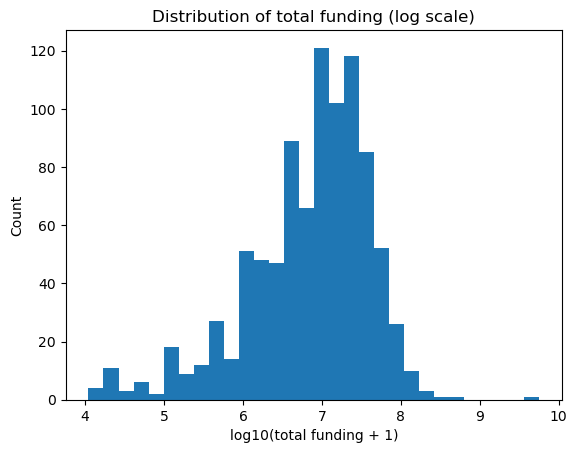

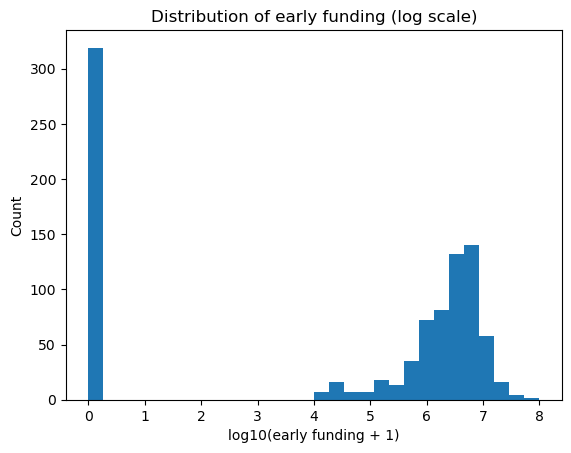

<Figure size 640x480 with 0 Axes>

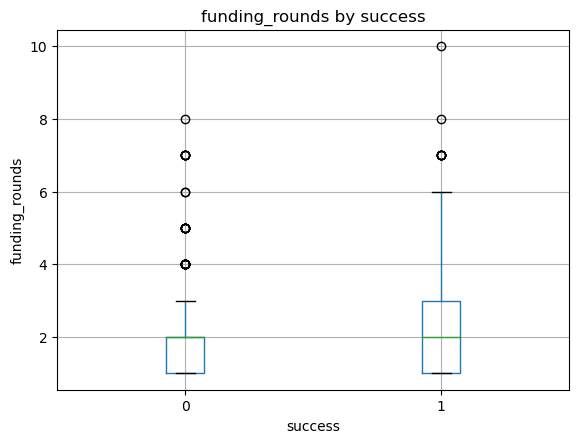

<Figure size 640x480 with 0 Axes>

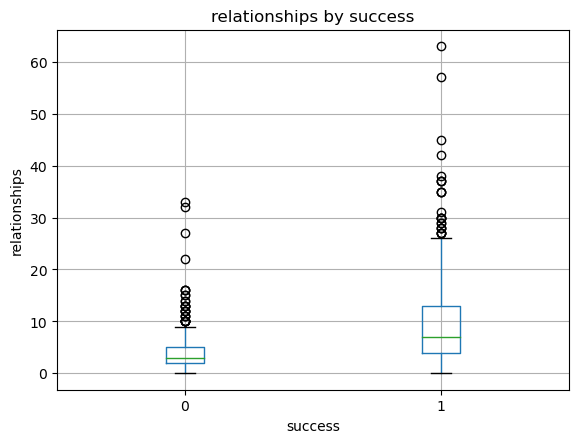

<Figure size 640x480 with 0 Axes>

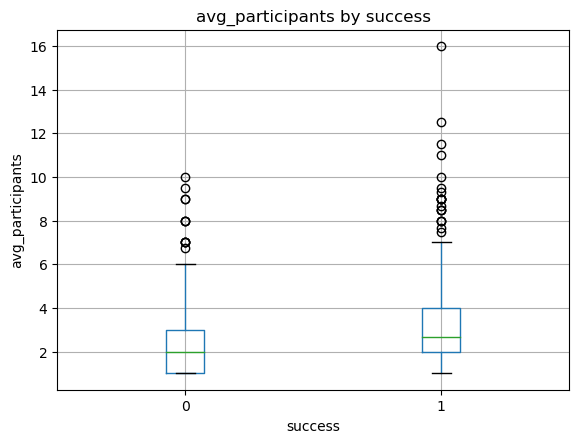

In [5]:
# Histogram of total funding (log scale to handle skew)
if 'funding_total_usd_main' in data.columns:
    plt.figure()
    data['funding_total_usd_main'].dropna().apply(lambda x: np.log10(x+1)).plot.hist(bins=30)
    plt.xlabel("log10(total funding + 1)")
    plt.ylabel("Count")
    plt.title("Distribution of total funding (log scale)")
    plt.show()

# Histogram of early_total_funding_usd
if 'early_total_funding_usd' in data.columns:
    plt.figure()
    data['early_total_funding_usd'].dropna().apply(lambda x: np.log10(x+1)).plot.hist(bins=30)
    plt.xlabel("log10(early funding + 1)")
    plt.ylabel("Count")
    plt.title("Distribution of early funding (log scale)")
    plt.show()

# Boxplots by success for a couple of key variables
for col in ['funding_rounds', 'relationships', 'avg_participants']:
    if col in data.columns:
        plt.figure()
        data.boxplot(column=col, by='success')
        plt.title(f"{col} by success")
        plt.suptitle("")
        plt.xlabel("success")
        plt.ylabel(col)
        plt.show()


In [6]:
# If we have category_code and/or market_group, look at success rates by those
if 'category_code' in data.columns:
    print("Top 10 category_code values:")
    print(data['category_code'].value_counts().head(10))

if 'market_group' in data.columns:
    print("\nSuccess vs market_group:")
    ct = pd.crosstab(data['market_group'], data['success'])
    display(ct)
    chi2, p, dof, expected = stats.chi2_contingency(ct)
    print(f"Chi-square test (market_group vs success): chi2={chi2:.3f}, dof={dof}, p={p:.3f}")

if 'state_code' in data.columns:
    print("\nTop 10 state_code values:")
    print(data['state_code'].value_counts().head(10))

    ct_state = pd.crosstab(data['state_code'].isin(['CA','NY','MA','TX']), data['success'])
    ct_state.index = ['other_states', 'CA/NY/MA/TX']
    print("\nSuccess vs large vs other states (coarse grouping):")
    display(ct_state)


Top 10 category_code values:
software           154
web                144
mobile              80
enterprise          75
advertising         62
games_video         52
semiconductor       35
network_hosting     34
biotech             34
hardware            27
Name: category_code, dtype: int64

Top 10 state_code values:
CA    492
NY    106
MA     83
TX     42
WA     42
CO     19
IL     18
PA     17
VA     13
GA     11
Name: state_code, dtype: int64

Success vs large vs other states (coarse grouping):


success,0,1
other_states,103,101
CA/NY/MA/TX,224,499


In [7]:
# ============================================
# 0) Ensure date columns are datetime
# ============================================
for col in ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']:
    if col in data.columns and not np.issubdtype(data[col].dtype, np.datetime64):
        data[col] = pd.to_datetime(data[col], errors='coerce')

# ============================================
# 1) Compute snapshot date (global latest date)
# ============================================
date_cols = [c for c in ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
             if c in data.columns]
all_maxes = [data[c].max() for c in date_cols if data[c].notna().any()]
snapshot_date = max(all_maxes)

print("Global snapshot date:", snapshot_date.date())

# ============================================
# 2) Outcome-based age:
#    - if status == 'closed'  & closed_at exists   -> event = closed_at
#    - elif status == 'acquired' & last_funding_at exists -> event = last_funding_at
#    - else                                       -> event = snapshot_date
# ============================================
if 'status' not in data.columns:
    raise ValueError("Expected a 'status' column in data (e.g. 'closed', 'acquired').")

event_date = pd.Series(snapshot_date, index=data.index)

mask_closed = data['status'].eq('closed') & data['closed_at'].notna()
event_date.loc[mask_closed] = data.loc[mask_closed, 'closed_at']

mask_acq = data['status'].eq('acquired') & data['last_funding_at'].notna()
event_date.loc[mask_acq] = data.loc[mask_acq, 'last_funding_at']

age_days = (event_date - data['founded_at']).dt.days
data['age_years_outcome'] = age_days / 365.25

# Filter to valid ages and success labels
mask_valid = (~data['age_years_outcome'].isna()) & (data['age_years_outcome'] >= 0) & data['success'].notna()
df = data[mask_valid].copy()

print("Non-missing startups for outcome-based age:", len(df))
print("Age range (years):", float(df['age_years_outcome'].min()),
      "to", float(df['age_years_outcome'].max()))

# ============================================
# 3) Age bins: 0–5, 5–10, 10+
# ============================================
bins = [0, 5, 10, 100]  # 100 as a big upper bound
labels = ['0-5', '5-10', '10+']
df['age_bin_3'] = pd.cut(
    df['age_years_outcome'],
    bins=bins, labels=labels, right=False
)

print("\nAge bin counts (outcome-based):")
print(df['age_bin_3'].value_counts().sort_index())

# ============================================
# 4) Derived features we need
# ============================================

# H1 / H5: relationships per funding round
df['rel_per_round'] = np.where(
    df['funding_rounds'] > 0,
    df['relationships'] / df['funding_rounds'],
    np.nan
)

# Columns for H2–H4 sanity check
needed_cols = ['avg_participants', 'age_first_funding_year', 'early_total_funding_usd']
for c in needed_cols:
    if c not in df.columns:
        print(f"[Warning] Column '{c}' not found; tests involving it will be skipped.")

# ---------- Seed-related features for H6 ----------
df['has_seed'] = df['seed'].fillna(0) > 0

stage_cols = ['angel', 'round_A', 'round_B', 'round_C',
              'round_D', 'round_E', 'round_F', 'round_G', 'round_H']
for c in stage_cols:
    if c not in df.columns:
        df[c] = 0.0

df['other_stage_sum'] = df[stage_cols].fillna(0).sum(axis=1)
df['seed_only'] = df['has_seed'] & (df['other_stage_sum'] == 0)

# Choose total funding column
if 'funding_total_usd_main' in df.columns:
    total_funding = df['funding_total_usd_main']
elif 'funding_total_usd_cb' in df.columns:
    total_funding = df['funding_total_usd_cb']
else:
    raise ValueError("Need a total funding column like 'funding_total_usd_main' or 'funding_total_usd_cb'.")

total_funding_safe = total_funding.replace(0, np.nan)

df['seed_share_total'] = df['seed'] / total_funding_safe

avg_round_size = total_funding_safe / df['funding_rounds'].replace(0, np.nan)
df['seed_over_avg_round'] = df['seed'] / avg_round_size

# ============================================
# Helper: t-test success vs fail
# ============================================
def ttest_by_success(df_sub, colname, min_per_group=5):
    """Two-sided t-test for difference in means of colname between success=1 and success=0."""
    if colname not in df_sub.columns:
        return {'n_success': 0, 'n_fail': 0,
                'mean_success': np.nan, 'mean_fail': np.nan,
                'median_success': np.nan, 'median_fail': np.nan,
                't_stat': np.nan, 'p_two_sided': np.nan}

    sub = df_sub.dropna(subset=[colname, 'success'])
    succ = sub[sub['success'] == 1][colname]
    fail = sub[sub['success'] == 0][colname]
    res = {
        'n_success': int(len(succ)),
        'n_fail': int(len(fail)),
        'mean_success': float(succ.mean()) if len(succ) > 0 else np.nan,
        'mean_fail': float(fail.mean()) if len(fail) > 0 else np.nan,
        'median_success': float(succ.median()) if len(succ) > 0 else np.nan,
        'median_fail': float(fail.median()) if len(fail) > 0 else np.nan,
    }
    if len(succ) >= min_per_group and len(fail) >= min_per_group:
        t_stat, p_two = stats.ttest_ind(succ, fail, equal_var=False)
        res.update({
            't_stat': float(t_stat),
            'p_two_sided': float(p_two),
        })
    else:
        res.update({
            't_stat': np.nan,
            'p_two_sided': np.nan,
        })
    return res


Global snapshot date: 2013-11-20
Non-missing startups for outcome-based age: 921
Age range (years): 0.0 to 28.386036960985628

Age bin counts (outcome-based):
0-5     553
5-10    311
10+      57
Name: age_bin_3, dtype: int64


In [8]:
alpha = 0.05  # significance level

def print_decision(h_name, res, description="the mean is the same for success and failure"):
    """
    Simple helper to print a 'reject / fail to reject H0' message
    using the two-sided p-value in res['p_two_sided'].
    """
    p = res.get('p_two_sided', np.nan)
    print(f"\nDecision for {h_name}:")
    if np.isnan(p):
        print("  p-value is NaN (probably not enough data). We cannot perform this test.")
        return
    print(f"  p-value = {p:.4g}")
    if p < alpha:
        print(f"  -> Reject H0 at alpha = {alpha}.")
        print(f"     There is statistical evidence that {description}.")
    else:
        print(f"  -> Fail to reject H0 at alpha = {alpha}.")
        print(f"     We do NOT see strong evidence that {description}.")

# ============================================
# H1: rel_per_round vs success (overall)
# ============================================
print("\n================ H1: rel_per_round vs success (overall) ================")
res_H1 = ttest_by_success(df, 'rel_per_round')
for k, v in res_H1.items():
    print(f"{k}: {v}")
print_decision(
    "H1",
    res_H1,
    description="the average relationships per funding round is different between successful and failed startups"
)

# ============================================
# H2: avg_participants vs success (overall)
# ============================================
print("\n================ H2: avg_participants vs success (overall) ================")
res_H2 = ttest_by_success(df, 'avg_participants')
for k, v in res_H2.items():
    print(f"{k}: {v}")
print_decision(
    "H2",
    res_H2,
    description="the average number of participants (investors) per round is different between successful and failed startups"
)

# ============================================
# H3: age_first_funding_year vs success (overall)
# ============================================
print("\n================ H3: age_first_funding_year vs success (overall) ================")
res_H3 = ttest_by_success(df, 'age_first_funding_year')
for k, v in res_H3.items():
    print(f"{k}: {v}")
print_decision(
    "H3",
    res_H3,
    description="the average time to first funding (in years since founding) is different between successful and failed startups"
)

# ============================================
# H4: early_total_funding_usd vs success (overall)
# ============================================
print("\n================ H4: early_total_funding_usd vs success (overall) ================")
res_H4 = ttest_by_success(df, 'early_total_funding_usd')
for k, v in res_H4.items():
    print(f"{k}: {v}")
print_decision(
    "H4",
    res_H4,
    description="the average early total funding (USD) is different between successful and failed startups"
)

# ============================================
# H5: Robustness of H1 – rel_per_round vs success within age bins
# ============================================
print("\n================ H5: rel_per_round vs success within age bins ================")
for age_label in labels:
    sub = df[df['age_bin_3'] == age_label].copy()
    if sub['success'].nunique() < 2:
        print(f"\nAge bin {age_label}: only one success value present, skipping t-test.")
        continue
    print(f"\nAge bin {age_label}: n={len(sub)}, success={int((sub['success']==1).sum())}, fail={int((sub['success']==0).sum())}")
    res = ttest_by_success(sub, 'rel_per_round')
    for k, v in res.items():
        print(f"{k}: {v}")
    print_decision(
        f"H5 (age bin {age_label})",
        res,
        description="the average relationships per round is different between successful and failed startups in this age group"
    )

# ============================================
# H6: Seed ratios among non–seed-only, seed-funded startups
# ============================================
seed_df = df[df['has_seed']].copy()
seed_multi = seed_df[~seed_df['seed_only']].copy()

print("\n================ H6: Seed ratios among non–seed-only, seed-funded startups ================")
print("Non-seed-only, seed-funded startups count:", len(seed_multi))

print("\n-- seed_share_total (seed / total funding) --")
res_H6_1 = ttest_by_success(seed_multi, 'seed_share_total')
for k, v in res_H6_1.items():
    print(f"{k}: {v}")
print_decision(
    "H6-a (seed_share_total)",
    res_H6_1,
    description="the average seed share of total funding is different between successful and failed startups (within this subgroup)"
)

print("\n-- seed_over_avg_round (seed / avg round size) --")
res_H6_2 = ttest_by_success(seed_multi, 'seed_over_avg_round')
for k, v in res_H6_2.items():
    print(f"{k}: {v}")
print_decision(
    "H6-b (seed_over_avg_round)",
    res_H6_2,
    description="the average seed size relative to the average round size is different between successful and failed startups (within this subgroup)"
)



================ H1: rel_per_round vs success (overall) ================
n_success: 596
n_fail: 325
mean_success: 4.497984579737936
mean_fail: 2.5711868131868134
median_success: 3.5
median_fail: 2.0
t_stat: 8.532657548370441
p_two_sided: 6.966979460651693e-17

Decision for H1:
  p-value = 6.967e-17
  -> Reject H0 at alpha = 0.05.
     There is statistical evidence that the average relationships per funding round is different between successful and failed startups.

================ H2: avg_participants vs success (overall) ================
n_success: 596
n_fail: 325
mean_success: 3.1038043624161076
mean_fail: 2.352761846153846
median_success: 2.6667
median_fail: 2.0
t_stat: 6.251535658564285
p_two_sided: 6.746465754720149e-10

Decision for H2:
  p-value = 6.746e-10
  -> Reject H0 at alpha = 0.05.
     There is statistical evidence that the average number of participants (investors) per round is different between successful and failed startups.

================ H3: age_first_funding_y

## Summary of Step 2 Findings (H1–H6)

- **H1 – Network intensity (`rel_per_round`)**  
  Successful startups have **significantly higher relationships per funding round** than failed ones (p ≪ 0.001).

- **H2 – Investor crowding (`avg_participants`)**  
  Successful startups have **more investors per round on average** than failed startups (p ≪ 0.001).

- **H3 – Time to first funding (`age_first_funding_year`)**  
  Successful startups reach their **first funding slightly earlier** than failed startups (p ≈ 0.03).

- **H4 – Early funding amount (`early_total_funding_usd`)**  
  Successful startups raise **more early funding** than failed startups (p < 0.001).

- **H5 – Robustness across age (0–5, 5–10, 10+ years)**  
  The network effect from H1 (higher `rel_per_round` for successful startups) remains **significant** in the **0–5** and **5–10** year age groups, and has the same direction in the **10+** group but is not statistically conclusive there due to small sample size.

- **H6 – Seed ratios among non–seed-only startups**  
  For startups that raised both **seed and later rounds**, the **relative size of the seed round** (over total funding or over average round size) **does not significantly differ** between success and failure.  
  In other words, within this subgroup, comparing seed to later rounds **does not help distinguish** successful vs failed startups.
